In [5]:
#cleaned up presentation of actual main program (no imports)

tickers = input("Please provide stock symbols separated by commas, max 5:") #aapl (Apple, inc.)
x, y = getStockData(tickers)

Please provide stock symbols separated by commas, max 5: V, AMZN, MSFT, ZM


In [6]:
x

{'V': 'Visa Inc.',
 'AMZN': 'Amazon.com, Inc.',
 'MSFT': 'Microsoft Corporation',
 'ZM': 'Zoom Video Communications, Inc.',
 '%5EGSPC': 'S&P 500'}

## Web Scraping / Data Gathering Module

In [2]:
#%%writefile CS_StockData.py

import requests
from bs4 import BeautifulSoup
from time import sleep
import csv 
import pandas as pd
import numpy as np
import re

def getStockData(user_input):
    '''Pulls data from Yahoo Finance'''

    tickers = cleanUserStockInput(user_input)
    
    stockData = {}
    stockNames = {}
    
    for stock in tickers:
        try:
            stock_url = "https://finance.yahoo.com/quote/"+stock+"/history?p="+stock+""
            r = requests.get(stock_url)
            data = r.text
            soup = BeautifulSoup(data)

            contents = []

            for row in soup.find_all('tbody'):    
                for srow in row.find_all('tr'):
                    for content in srow.find_all('td'):
                        if "Dividend" in content.text:
                            #removes prior entry of date of dividend data point and ignores dividend data point
                            contents.pop() 
                            continue
                        else:
                            contents.append(content.text)
            
            stockData[stock] = defineStockData(contents)
            stockNames[stock] = defineStockName(stock)

        except:
            continue
            #stockErrors.append(stock)
            
        #delay added to avoid triggering web scrapping blocks
        delay = [0.1, 0.5, 1, 2, 2.5]
        delay = np.random.choice(delay)

        sleep(delay)
    
    return stockNames, stockData


def defineStockData(raw_list):
    '''Transforming scraped stock data into columns of data'''

    #the 7 columns of data, decided not to include most in this analysis
    date=[]
    open_price=[]
    high_price=[]
    low_price=[]
    close_price=[]
    adj_close_price=[]
    volume = []
    percent_change = []
    normalized_returns = []

    #pulled all data into one long list, but there are 7 columns of data
    #list comprehension to break out the full list in groupings by the 7 columns
    adj_contents = [raw_list[i * 7:(i + 1) * 7] for i in range((len(raw_list) + 7 - 1) // 7 )]

    #assigning the values to the columns
    for i in range(0, len(adj_contents)): #change to a count for amount of days requested...up to 97
        date.append(adj_contents[i][0])
        open_price.append(float(adj_contents[i][1].replace(",","")))
        high_price.append(float(adj_contents[i][2].replace(",","")))
        low_price.append(float(adj_contents[i][3].replace(",","")))
        close_price.append(float(adj_contents[i][4].replace(",","")))
        adj_close_price.append(float(adj_contents[i][5].replace(",","")))
        volume.append(float(adj_contents[i][6].replace(",","")))

    #calculating the percent change from prior close to today        
    for j in range(0, len(adj_close_price)):
        if j == len(adj_close_price)-1:
            percent_change.append(0.00)
        else:
            percent_change.append(round(adj_close_price[j]/adj_close_price[j+1]-1,3))

    #normalizing returns for comparison across companies
    normalizer = 100

    for x in range(len(percent_change), 0,-1):
        if x == len(percent_change):
            normalized_returns.append(normalizer)
        else:
            normalizer = round(normalizer * (1+percent_change[x-1]),3)
            normalized_returns.append(normalizer)

    normalized_returns.reverse()

    return addStockToDF(date, open_price, high_price, low_price, close_price, adj_close_price, volume, percent_change,normalized_returns)



def addStockToDF(date,open_price,high_price,low_price,close_price,adj_close_price,volume, percent_change,normalized_returns):
    '''Placing stock data into panda data frame'''
    #placing the values into a panda data frame
    x = pd.DataFrame({"Date": date,
                      "Open Price": open_price,
                      "High Price": high_price,
                      "Low Price": low_price,
                      "Close Price": close_price,
                      "Adj Close Price": adj_close_price,
                      "Volume":volume,
                      "Percent Change": percent_change,
                      "Normalized Returns": normalized_returns})
    x["Date"] = pd.to_datetime(x["Date"]) #allows interpretation as dates vs. ordered numbers

    #placing data frame into dictionary with stock ticker as key
    return x



def cleanUserStockInput(tickers):
    '''Cleans and formats user stock input'''
    tickers = tickers.split(",")

    #clean up white space and make all tickers upper case
    for x in range(0,len(tickers)):
        tickers[x] = tickers[x].strip()
        tickers[x] = tickers[x].upper()
        
    if len(tickers) > 1:
        tickers.append('%5EGSPC')

    return tickers
    

def defineStockName(ticker):
    '''Matches ticker with company name from CSV file'''
    
    #list obtained from https://dumbstockapi.com/
    stockList = pd.read_csv("StockInformationList.csv")
        
    for y in range(0, len(stockList)):
        if ticker == stockList["ticker"][y]:
            return stockList["name"][y]     
        elif ticker == "%5EGSPC":
            return "S&P 500"


def pullStockInformationList():
    '''Downloads CSV file of Ticker:Copmany Name'''
    # Question whether we want this as an option(?)


## Data Processing Module

In [3]:
import pandas as pd
import numpy as np
from math import sqrt


##########################################################
# Moving Average Convergence-Divergence


def calcMACD(df,ma_fast,ma_slow,macd_period):
    '''Moving Average Convergence Divergence (MACD)'''
    #ma_fast is periods included in fast moving average
    #ma_slow is periods included in fast moving average
    #macd_period is periods included in MA of MA

    ma_fast = calcMovingAverage(df,ma_fast)
    ma_slow = calcMovingAverage(df,ma_slow)
    ma_diff = []
    macd = []

    for x in range(0,len(ma_slow)):
        ma_diff.append(ma_fast[x]-ma_slow[x])
    
    macd = calcMovingAverage(ma_diff,macd_period)

    #lists of different lengths
    return ma_diff, macd


def calcMACDForGraphs(df,ma_fast,ma_slow,macd_period):
    '''Moving Average Convergence Divergence (MACD)'''

    ma_fast = calcMovingAverage(df,ma_fast)
    ma_slow = calcMovingAverage(df,ma_slow)
    ma_diff = []
    macd = []
    length = len(df)

    for x in range(0,len(ma_slow)):
        ma_diff.append(ma_fast[x]-ma_slow[x])
    
    macd = calcMovingAverage(ma_diff,macd_period)
    
    for x in range(0,length-len(ma_diff)):
        ma_diff.append(None)
    
    for x in range(0,length-len(macd)):
        macd.append(None)

    #lists of different lengths
    return ma_diff, macd


def calcMovingAverage(df, a):
    '''General moving average function'''
    length = len(df)-a
    ma_data =[]

    for x in range(0,length):
        total = 0
        for y in range(0, a):
            total += df[x+y]
        ma_data.append(total/a)

    return ma_data


def pullMACDPoints(ma_diff,macd):
    '''Identify index position of where MACD lines cross'''
    #initiate list to capture points where lines cross
    indexMACDpoints = []

    #running prior period value to determine if new value indicates lines crossed
    prior_period = 0

    for x in range(0, len(macd)):
        
        if x == 0:
            prior_period = ma_diff[x]-macd[x]
        
        else:
            current_period = ma_diff[x]-macd[x]

            if current_period < 0 and prior_period >= 0:
                indexMACDpoints.append([x,"buy"])
                prior_period = current_period
            elif current_period > 0 and prior_period <= 0:
                indexMACDpoints.append([x,"sell"])
                prior_period = current_period
            else:
                continue
    
    return indexMACDpoints


##########################################################
# Volume-Price Trend


def calcVolPriceTrend(df):
    '''Calculates volume-price trend for stock'''
    #https://www.daytrading.com/volume-price-trend
    #used to understand if movements in price are supported by significant volume
    
    vpt = []
    day = []
    daily_change = 0
    daily_vpt = 0

    for x in range(0,len(df)-1):
        daily_change = (df["Adj Close Price"][x+1]-df["Adj Close Price"][x])/df["Adj Close Price"][x]
        daily_vpt = daily_vpt + df["Volume"][x+1]*daily_change              
        vpt.append(daily_vpt)
        day.append(df["Date"][x+1])
    
    return day, vpt


##########################################################
# Descriptive Statistics


def pullMaxValue(df):
    '''Returns maximum stock price over period - may be intraday'''
    
    value = df["High Price"].max()
    
    for x in range(0, len(df)):
        if value == df["High Price"][x]:
            date = df["Date"][x]
    
    return [value, date]


def pullMinValue(df):
    '''Returns minimum stock price over period - may be intraday'''
    
    value = df["Low Price"].min()
    
    for x in range(0, len(df)):
        if value == df["Low Price"][x]:
            date = df["Date"][x]
    
    return [value, date]


def calcVolatility(df):
    '''Returns the stock volatility over the period'''

    #based on adjusted close price

    mean = df["Adj Close Price"].mean()
    n = df["Adj Close Price"].count()-1
    volatility = 0

    for x in range(0,len(df)):
        volatility += (mean-df["Adj Close Price"][x])**2

    volatility = round(volatility/n,2) 

    return volatility


def calcStandardDeviation(df):
    '''Calculates the standard deviation over the period'''
    
    std = round(sqrt(calcVolatility(df)),2)

    return std


def calcPeriodReturn(df, beg, end):
    '''Returns closing share price for the period'''
    
    beginning_price = df["Open Price"][beg]
    closing_price = df["Adj Close Price"][end]

    period_return = round((closing_price - beginning_price)/beginning_price,4)

    return period_return

def formatCurrency(df_col):
    '''Returns list of data frame column in currency format'''
    
    new_list = []
    
    for x in range(0,len(df_col)):
        new_list.append("${:,.2f}".format(df_col[x]))
    
    return new_list

def formatCommaNumber(df_col):
    '''Returns list of data frame column in comma format'''
    
    new_list = []
    
    for x in range(0,len(df_col)):
        new_list.append("{:,.2f}".format(df_col[x]))
    
    return new_list

def formatPercent(df_col):
    '''Returns list of data frame column in comma format'''
    
    new_list = []
    
    for x in range(0,len(df_col)):
        y = df_col[x]*100
        new_list.append("{:,.2f}%".format(y))
    
    return new_list

def calcAdjustedPeriod(df_col, length):
    '''Returns an adjusted length list'''
    
    new_list = []
    
    for x in range(0, length):
        new_list.append(df_col[x])
    
    return new_list 
        

def calcDescriptiveStats(df):
    return 


def calcComparativeStats(df):
    return 



## Graphing Module

Note I commented out the creation of the .py file and calling that file

In [12]:
#%%writefile CS_Graphing.py

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import pandas as pd

#from CS_DataProcessing import *

def showTableData(df, ticker):
    '''Table displaying all columns of stock data'''

    date_values = df[ticker]["Date"].dt.strftime('%m/%d/%Y')
    open_price = formatCurrency(df[ticker]["Open Price"])
    high_price = formatCurrency(df[ticker]["High Price"])
    low_price = formatCurrency(df[ticker]["Low Price"])
    close_price = formatCurrency(df[ticker]["Close Price"])
    adj_close = formatCurrency(df[ticker]["Adj Close Price"])
    volume = formatCommaNumber(df[ticker]["Volume"])
    percent = formatPercent(df[ticker]["Percent Change"])
    normalized = formatCurrency(df[ticker]["Normalized Returns"])
        
    fig = go.Figure(data=[go.Table(header=dict(values=list(df[ticker].columns),
                align='center'),
                cells=dict(values=[date_values,open_price,high_price,low_price,close_price,adj_close,volume,percent,normalized],
                align='right'))
                ])

    fig.update_layout(autosize=False, width=1200,height=900, margin=dict(
        l=50,
        r=50,
        b=50,
        t=100,
        pad=4
    ))

    fig.update_layout(title='Data Table for {}'.format(format(defineStockName(ticker))))

    fig.show()    

    
def graphSingleStockDefault(df,ticker):
    '''Default Graph for a single stock of price performance and volume'''
    #only for use in presentation - not dynamic due to titles/layout adjustments
    buildSingleStockLineChart(df, ticker)
    buildSingleStockVolumeBarChart(df,ticker)

    
def buildSingleStockLineChart(df, ticker):
    '''Creates a line graph of the adjusted close price for a single stock'''
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df[ticker]['Date'], y=formatCurrency(df[ticker]['Adj Close Price']),
                                    mode='lines',
                                    name=defineStockName(ticker))) 
    fig.update_layout(title='Historical Price and Volume Trends for '+defineStockName(ticker),
                       xaxis_title='Date',
                       yaxis_title='Adjusted Close Price', yaxis=dict(tickformat ="$.2"))
    
    fig.update_layout(autosize=False, width=1200,height=600, margin=dict(
        l=50,
        r=50,
        b=20,
        t=100,
        pad=4
    ))
    
    fig.show()

    
def buildSingleStockVolumeBarChart(df,ticker):
    '''Builds volume bar graph'''
    fig = go.Figure()
    fig.add_trace(go.Bar(x=df[ticker]['Date'],y=df[ticker]['Volume']))
    fig.update_layout(xaxis_title='Date', yaxis_title='Daily Trading Volume')

    fig.update_layout(autosize=False, width=1200,height=300, margin=dict(
        l=50,
        r=50,
        b=80,
        t=10,
        pad=4
    ))
    
    fig.show()  

    
def graphSingleStockPrediction(df, ticker, fast=12, slow=26, macd=9):
    '''Stacked charts of historical price and MACD'''
    #provides default values for the MACD analysis
    
    length = len(df[ticker]["Date"])-slow-macd
    buildSingleStockLineCharts2(df,ticker,length)
    graphMACD_buy_sell2(df, ticker, fast, slow, macd)


def buildSingleStockLineCharts2(df, ticker, length):
    '''Creates a line graph of the adjusted close price for a single stock'''
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df[ticker]['Date'], y=formatCurrency(df[ticker]['Adj Close Price']),
                                    mode='lines',
                                    name=defineStockName(ticker))) 
    fig.update_layout(title='Historical Price and MACD Trends for '+defineStockName(ticker),
                       xaxis_title='Date',
                       yaxis_title='Adjusted Close Price', yaxis=dict(tickformat ="$.2"))
    
    fig.update_layout(autosize=False, width=1200,height=600, margin=dict(
        l=50,
        r=50,
        b=20,
        t=100,
        pad=4
    ))
    
    fig.update_layout(shapes=[
        dict(
          type= 'line',
          yref= 'paper', y0= 0, y1= 1,
          xref= 'x', x0= df[ticker]["Date"][(length)], x1= df[ticker]["Date"][(length)],
          line=dict(
              color="Gray",
              width=2,
              dash="dash",
          )
        )
    ])
    

    fig.add_annotation(
                    x=df[ticker]["Date"][(length)],
                    y=df[ticker]["Adj Close Price"].min(),
                    text="MACD Analysis Range Begins",
                    textangle=90)
    
    fig.show()


def graphMACD_buy_sell2(df, ticker, fast, slow, macd):
    '''Simplifying MACD graph call by ticker'''

    ma_fast, ma_slow = calcMACD(df[ticker]["Adj Close Price"], fast, slow, macd)
    macd_index = pullMACDPoints(ma_fast, ma_slow)
    
    ma_fast2, ma_slow2 = calcMACDForGraphs(df[ticker]["Adj Close Price"], fast, slow, macd)
   
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df[ticker]["Date"], y=ma_fast2,
                        mode='lines',
                        name='fast MA'))
    fig.add_trace(go.Scatter(x=df[ticker]["Date"], y=ma_slow2,
                        mode='lines',
                        name='slow MA'))

    for x in range(0, len(macd_index)):
        fig.add_annotation(
                    x=df[ticker]["Date"][macd_index[x][0]],
                    y=ma_slow2[macd_index[x][0]],
                    text=macd_index[x][1])

    fig.update_annotations(dict(
                xref="x",
                yref="y",
                showarrow=True,
                arrowhead=7,
                ax=0,
                ay=-40
    ))

    fig.update_layout(autosize=False, width=1200,height=300, margin=dict(
        l=50,
        r=50,
        b=80,
        t=10,
        pad=4
    ))
    fig.update_layout(xaxis_title='Date',
                      yaxis_title='Moving Average Difference', yaxis=dict(tickformat ="$.2"))
    
    fig.update_layout(legend_orientation="h")
    
    fig.update_layout(shapes=[
        dict(
          type= 'line',
          yref= 'paper', y0= 0, y1= 1,
          xref= 'x', x0= df[ticker]["Date"][(len(df[ticker]["Date"])-slow-macd)], x1= df[ticker]["Date"][(len(df[ticker]["Date"])-slow-macd)],
          line=dict(
              color="Gray",
              width=2,
              dash="dash",
          )
        )
    ])  

    fig.show()

    
def graphMultipleStockDefault(df):
    '''Default Graph for a multiple stock comparitive performance and table'''
    #only for use in presentation - not dynamic due to titles/layout adjustments
    buildMultiStockLineGraph2(df)
    buildStatsTable2(df)


def buildMultiStockLineGraph2(df):
    '''Creates a line graph of the normalized returns for several stocks'''
    symbols = list(df.keys())
    fig = go.Figure()
    for symbol in symbols:
        if symbol == "%5EGSPC":
            fig.add_trace(go.Scatter(x=df[symbol]['Date'], y=df[symbol]['Normalized Returns'],
                                    mode='lines',
                                    marker = dict(color="Gray"),
                                    name="S&P 500")) 
        else: 
            fig.add_trace(go.Scatter(x=df[symbol]['Date'], y=df[symbol]['Normalized Returns'],
                                    mode='lines',
                                    name=symbol)) 
    fig.update_layout(title='Historical Normalized Returns for Selected Stocks',
                       xaxis_title='Date',
                       yaxis_title='Normalized Returns - Base 100')
    fig.update_layout(showlegend=True)
    fig.update_layout(autosize=False, width=1200,height=600, margin=dict(
        l=50,
        r=50,
        b=20,
        t=100,
        pad=4
    ))
    
    fig.update_layout(legend_orientation="h")
        
    fig.show()
    
def buildStatsTable2(df):
    '''Table displaying descriptive statistics for stocks'''
    symbols = list(df.keys())
    names = []
    period_return = []
    relative_return = []
    maxVals = []
    minVals = []
    stdevs = []
    
    # gets the descriptive statistics for all of the stocks entered:
    for symbol in symbols:
        names.append(defineStockName(symbol))
        period_return.append(calcPeriodReturn(df[symbol],(len(df[symbol])-1),0))
        
        if symbol == "%5EGSPC":
            relative_return.append(0)
        else:
            relative_return.append(calcPeriodReturn(df[symbol],(len(df[symbol])-1),0)-calcPeriodReturn(df["%5EGSPC"],(len(df["%5EGSPC"])-1),0))
        maxVal, maxDate = pullMaxValue(df[symbol])
        maxVals.append(maxVal)
        minVal, minDate = pullMinValue(df[symbol])
        minVals.append(minVal)
        stdev = calcStandardDeviation(df[symbol])
        stdevs.append(stdev)
        
    tableData = [names, formatPercent(period_return), formatPercent(relative_return), formatCurrency(minVals), formatCurrency(maxVals), formatCurrency(stdevs)]
        
    fig = go.Figure(data=[go.Table(
                columnorder=[1,2,3,4,5,6],
                columnwidth=[150,80,80,80,80,80],
                header=dict(values=['Stock','Period Return', 'S&P Relative Return', 'Minimum Value', 'Maximum Value', 'Standard Deviation'],
                align='center'),
                cells=dict(values=tableData,
                align=['left','right']))
                ])

    fig.update_layout(autosize=False, width=1200, height = 300, margin=dict(
        l=50,
        r=50,
        b=80,
        t=60,
        pad=4
    ))

    fig.update_layout(title='Descriptive Statistics for Selected Stocks')

    fig.show()
    

    
    
#########################################################################################################    
############################# OLDER FILES BELOW #########################################################    
#########################################################################################################    



    
def buildVolumeBarChart(stockData):
    '''Builds volume bar graph'''
    symbols = list(stockData.keys())
    symbol = symbols[0]
    fig = go.Figure()
    fig.add_trace(go.Bar(x=stockData[symbol]['Date'],y=stockData[symbol]['Volume']))
    fig.update_layout(title='Volume Bar Chart for '+symbol,
                   xaxis_title='Date',
                   yaxis_title='Trading Volume')
    fig.show()    
    
    
def buildMultiStockLineGraph(stockData):
    '''Creates a line graph of the normalized returns for several stocks'''
    symbols = list(stockData.keys())
    fig = go.Figure()
    for symbol in symbols:
        fig.add_trace(go.Scatter(x=stockData[symbol]['Date'], y=stockData[symbol]['Normalized Returns'],
                                    mode='lines',
                                    name=symbol)) 
    fig.update_layout(title='Normalized Returns for Selected Stocks',
                       xaxis_title='Date',
                       yaxis_title='Normalized Returns')
    fig.update_layout(showlegend=True)
    fig.show()

def buildSingleStockLineGraph(stockData):
    '''Creates a line graph of the adjusted close price for a single stock'''
    symbols = list(stockData.keys())
    fig = go.Figure()
    for symbol in symbols:
        fig.add_trace(go.Scatter(x=stockData[symbol]['Date'], y=stockData[symbol]['Adj Close Price'],
                                    mode='lines',
                                    name=symbol)) 
    fig.update_layout(title='Adjusted Close Price for '+symbol,
                       xaxis_title='Date',
                       yaxis_title='Adj Close Price')
    fig.show()
    
def buildStockAndWordLineGraph(stockData, wordData):
    # place holder
    pass

def buildMultiStockAndWordGraph(stockData, wordData):
    # place holder
    pass

def buildStatsTable(stockData):
    '''Table displaying descriptive statistics for stocks'''
    symbols = list(stockData.keys())
        
    maxVals = []
    maxDates = []
    minVals = []
    minDates = []
    volatils = []
    stdevs = []
#     pdRets = []
    
    # gets the descriptive statistics for all of the stocks entered:
    for symbol in symbols:
        maxVal, maxDate = pullMaxValue(stockData[symbol])
        maxVals.append(maxVal)
        maxDates.append(maxDate.strftime('%m/%d/%Y'))
        minVal, minDate = pullMinValue(stockData[symbol])
        minVals.append(minVal)
        minDates.append(minDate.strftime('%m/%d/%Y'))
        volatil = calcVolatility(stockData[symbol])
        volatils.append(volatil)
        stdev = calcStandardDeviation(stockData[symbol])
        stdevs.append(stdev)
#         pdRet = calcPeriodReturn(stockData[symbol], beginning, end)
#         pdRets.append(pdRet)
        
    tableData = [symbols, maxVals, maxDates, minVals, minDates, volatils, stdevs]
        
    fig = go.Figure(data=[go.Table(header=dict(values=['Stock', 'Maximum Value', 'Date of Max Val', 'Minimum Value', 'Date of Min Val', 'Volatility', 'Standard Deviation'],
                align='left'),
                cells=dict(values=tableData,
                align='left'))
                ])

    fig.update_layout(autosize=False, width=1200,height=500, margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ))

    fig.update_layout(title='Descriptive Statistics for Selected Stocks')

    fig.show()

def graphMACD_buy_sell(df, ticker, fast, slow, macd):
    '''Simplifying MACD graph call by ticker'''

    ma_fast, ma_slow = calcMACD(df[ticker]["Adj Close Price"], fast, slow, macd)
    macd_index = pullMACDPoints(ma_fast, ma_slow)
    x_axis = []

    for x in range(0,len(ma_slow)):
        x_axis.append(df[ticker]["Date"][x])
   
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_axis, y=ma_fast,
                        mode='lines',
                        name='fast MA'))
    fig.add_trace(go.Scatter(x=x_axis, y=ma_slow,
                        mode='lines',
                        name='slow MA'))

    for x in range(0, len(macd_index)):
        fig.add_annotation(
                    x=x_axis[macd_index[x][0]],
                    y=ma_slow[macd_index[x][0]],
                    text=macd_index[x][1])

    fig.update_annotations(dict(
                xref="x",
                yref="y",
                showarrow=True,
                arrowhead=7,
                ax=0,
                ay=-40
    ))

    fig.update_layout(title='MACD of {}'.format(defineStockName(ticker)))

    fig.show()


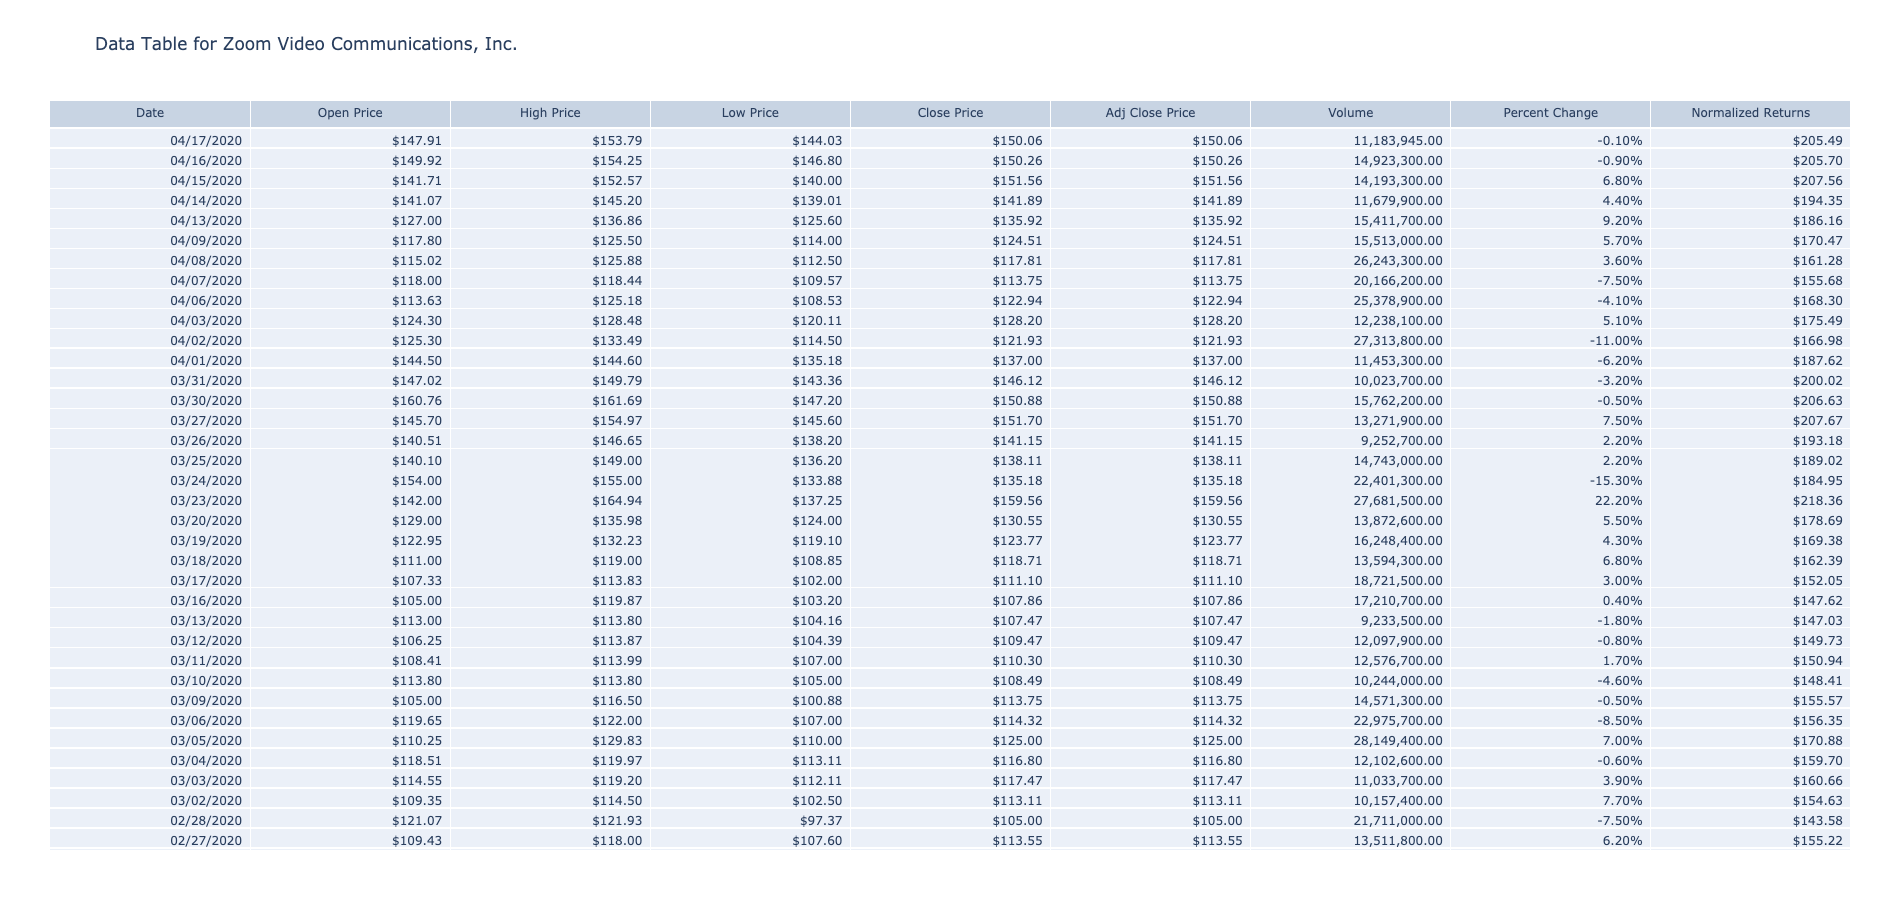

In [8]:
showTableData(y,"ZM")

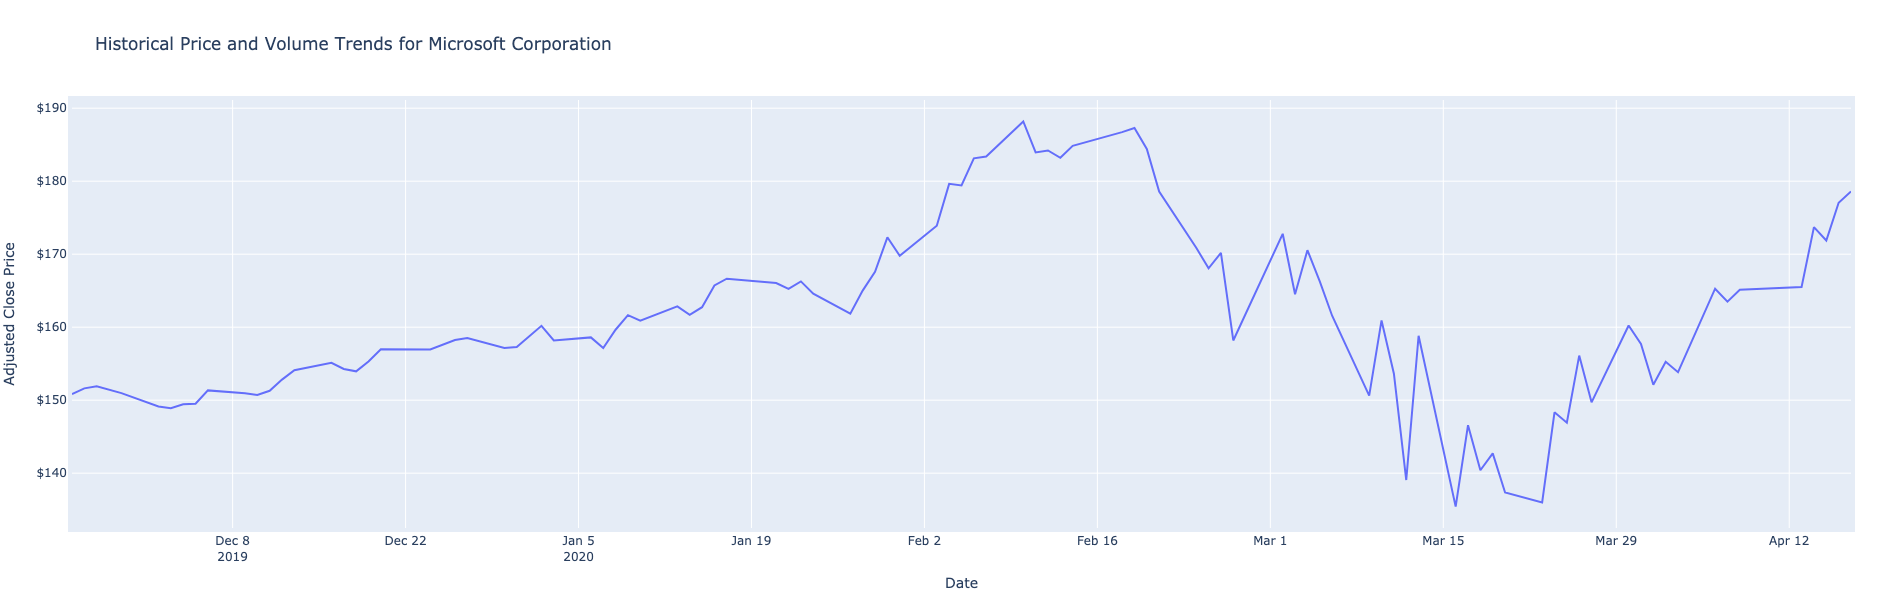

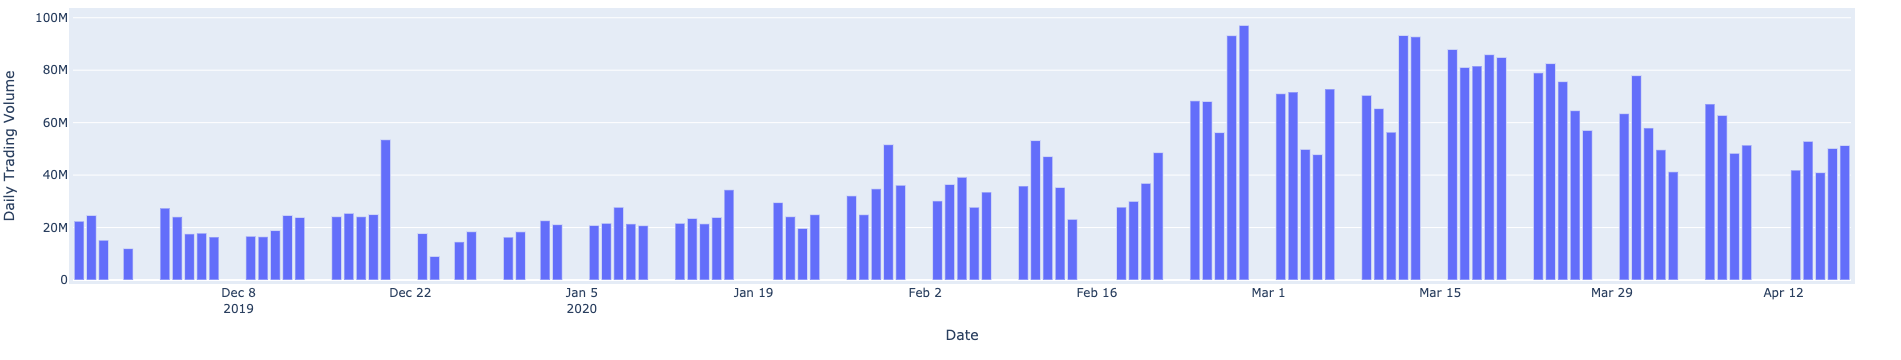

In [9]:
graphSingleStockDefault(y,"MSFT")

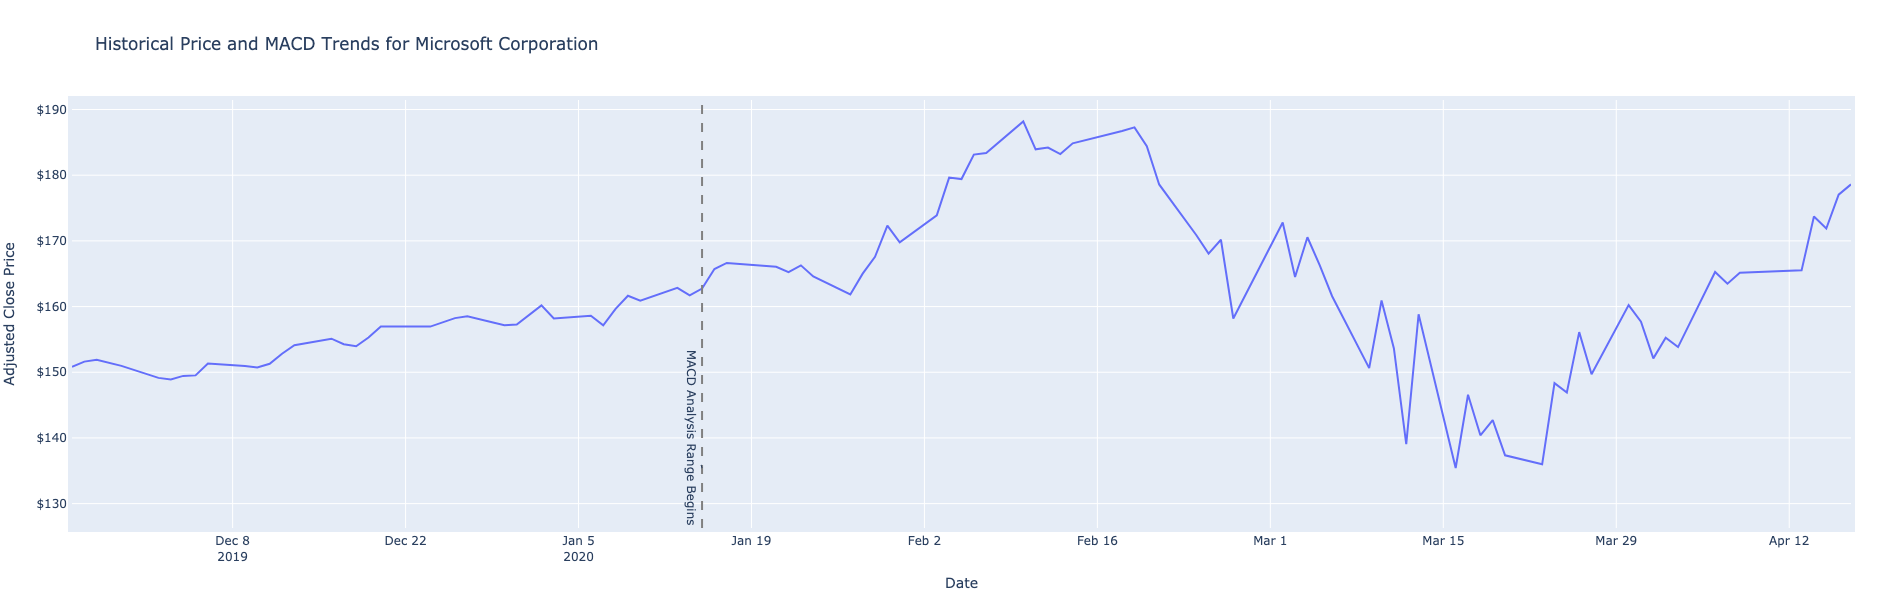

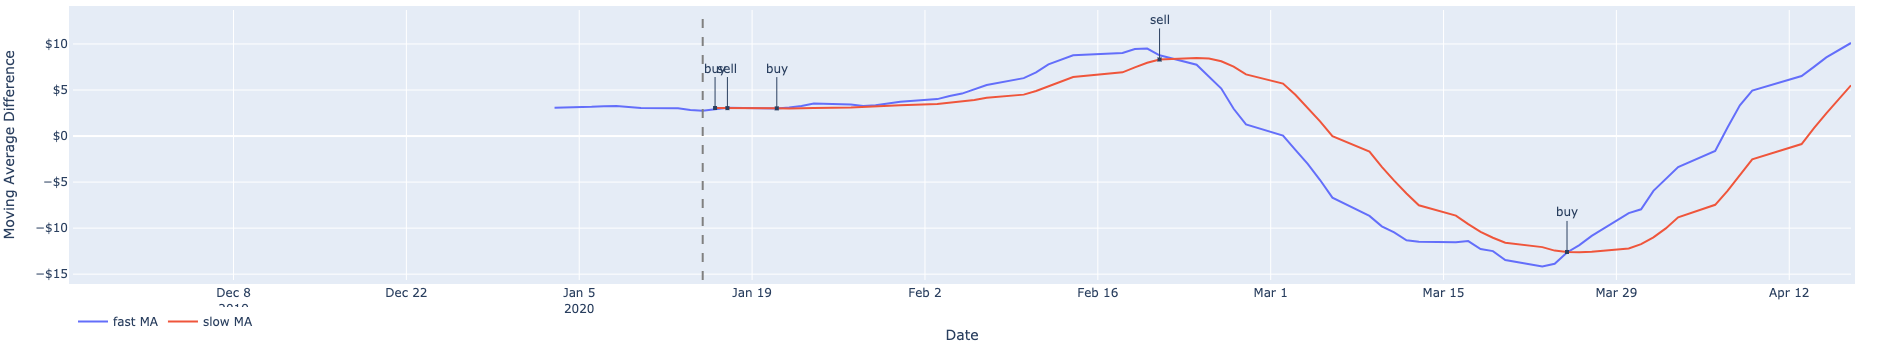

In [10]:
graphSingleStockPrediction(y, "MSFT")

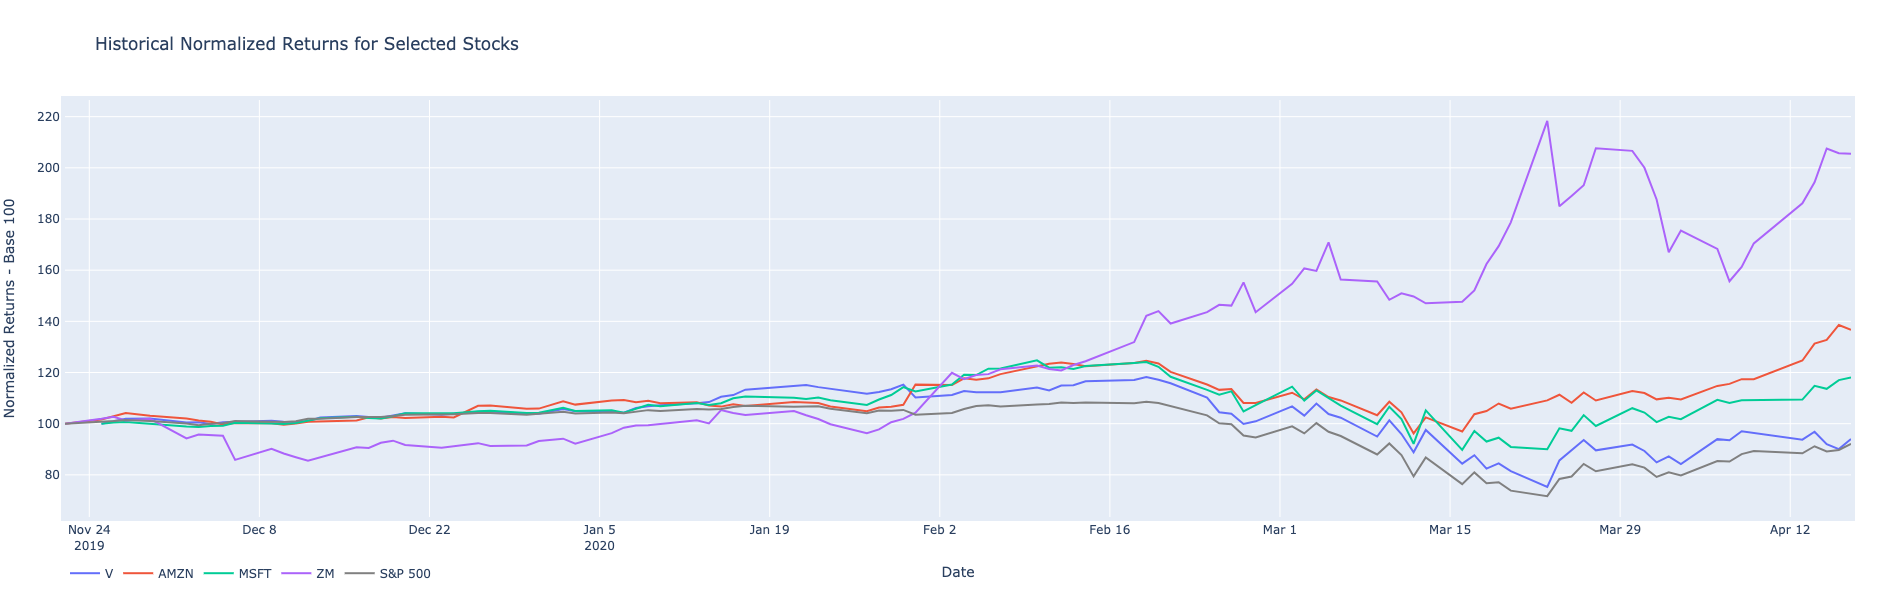

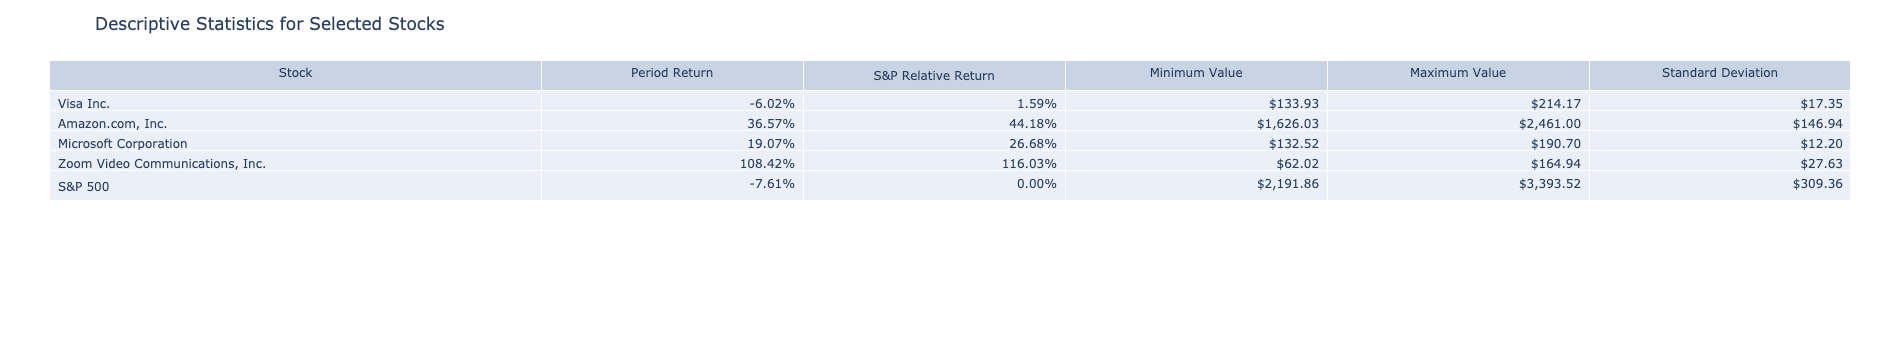

In [11]:
graphMultipleStockDefault(y)

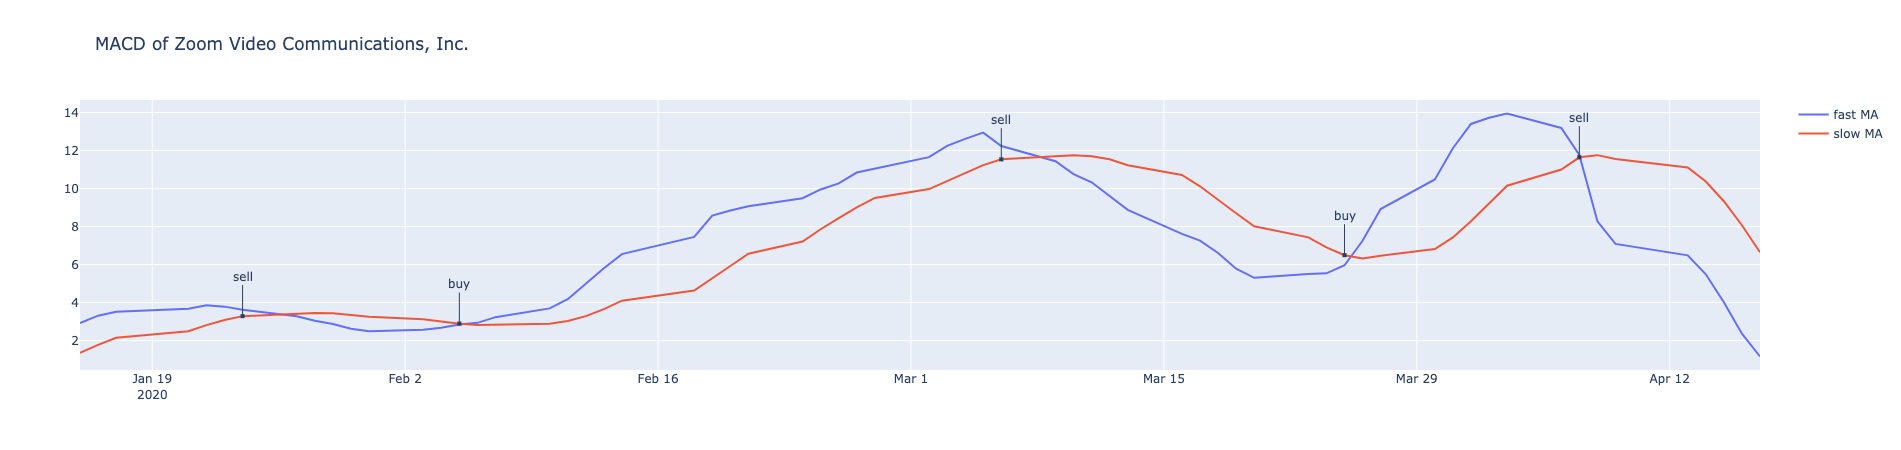

interactive(children=(IntSlider(value=9, description='macd', max=27, min=-9), Output(layout=Layout(height='350…

In [7]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(x):
    return x

#interact(f, x = 5);
#interactive(graphMACD_buy_sell(y,"ZM",12,26,9), macd=9)

interactive_plot = interactive(graphMACD_buy_sell(y,"ZM",12,26,9), macd=9)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot
